# E-commerce Customer Satisfaction Analysis

## Objective
This notebook analyzes customer satisfaction levels using data from an e-commerce customer behavior dataset. The goal is to understand how satisfaction depends on other behavioral and demographic parameters such as spending, product ratings, membership type, and more.

----
authors:
- Jakub Piotrowski (266502)
- Jakub Włodarski (288763
)

subject: Anlysis of Web Based Systems (project2)


In [5]:
import pandas as pd

file_path = ('../data/E-commerce Customer Behavior - Sheet1.csv')
df = pd.read_csv(file_path)

df.head()

,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level
0,101,Female,29,New York,Gold,1120.20,14,4.6,True,25,Satisfied
1,102,Male,34,Los Angeles,Silver,780.50,11,4.1,False,18,Neutral
2,103,Female,43,Chicago,Bronze,510.75,9,3.4,True,42,Unsatisfied
3,104,Male,30,San Francisco,Gold,1480.30,19,4.7,False,12,Satisfied
4,105,Male,27,Miami,Silver,720.40,13,4.0,True,55,Unsatisfied


In [6]:
df.info()
df.describe()
df.columns
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               350 non-null    int64  
 1   Gender                    350 non-null    object 
 2   Age                       350 non-null    int64  
 3   City                      350 non-null    object 
 4   Membership Type           350 non-null    object 
 5   Total Spend               350 non-null    float64
 6   Items Purchased           350 non-null    int64  
 7   Average Rating            350 non-null    float64
 8   Discount Applied          350 non-null    bool   
 9   Days Since Last Purchase  350 non-null    int64  
 10  Satisfaction Level        348 non-null    object 
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 27.8+ KB


Customer ID                 0
Gender                      0
Age                         0
City                        0
Membership Type             0
Total Spend                 0
Items Purchased             0
Average Rating              0
Discount Applied            0
Days Since Last Purchase    0
Satisfaction Level          2
dtype: int64

## Data Overview & Preparation

We began by loading the dataset and performing a basic exploratory data analysis. The dataset contains 350 entries with features like:

- `Total Spend`
- `Items Purchased`
- `Average Rating`
- `Membership Type`
- `Days Since Last Purchase`
- ...and the target: `Satisfaction Level` (Satisfied / Neutral / Unsatisfied)

Two missing values in the `Satisfaction Level` column were found and removed to ensure data quality.


In [7]:
print(df.columns.tolist())

['Customer ID', 'Gender', 'Age', 'City', 'Membership Type', 'Total Spend', 'Items Purchased', 'Average Rating', 'Discount Applied', 'Days Since Last Purchase', 'Satisfaction Level']


In [8]:
# Check missing values
df['Satisfaction Level'].isnull().sum()

# Drop or fill missing satisfaction values (drop is okay since it's just 2 rows)
df = df.dropna(subset=['Satisfaction Level'])


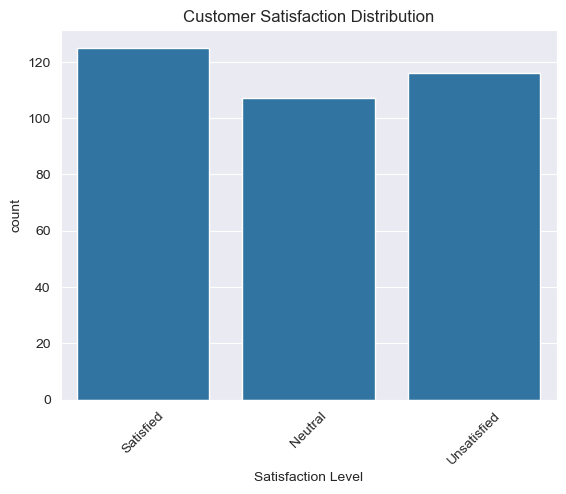

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='Satisfaction Level')
plt.title('Customer Satisfaction Distribution')
plt.xticks(rotation=45)
plt.show()


### Satisfaction Distribution

The majority of customers reported being either satisfied or unsatisfied, with a slightly lower count in the neutral category. This indicates polarized feedback.


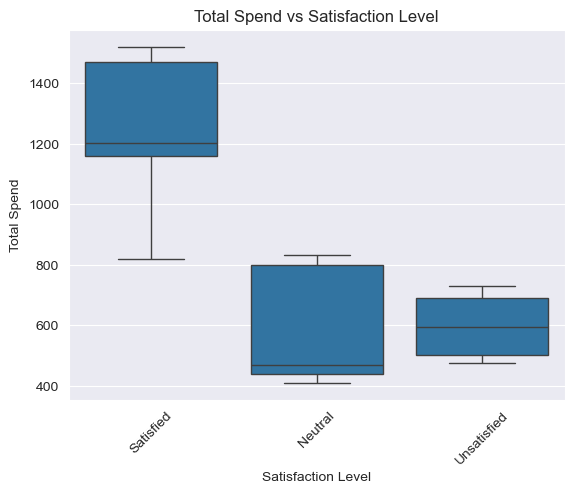

In [10]:
sns.boxplot(data=df, x='Satisfaction Level', y='Total Spend')
plt.title('Total Spend vs Satisfaction Level')
plt.xticks(rotation=45)
plt.show()


### Total Spend by Satisfaction

Satisfied customers have significantly higher spending, while unsatisfied customers tend to spend the least. This suggests that spending may positively influence satisfaction.


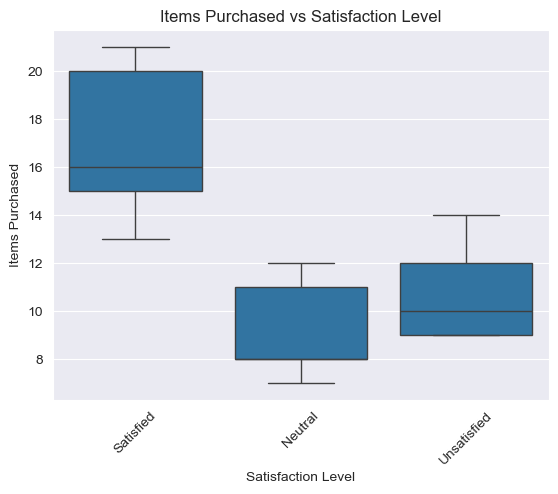

In [11]:
sns.boxplot(data=df, x='Satisfaction Level', y='Items Purchased')
plt.title('Items Purchased vs Satisfaction Level')
plt.xticks(rotation=45)
plt.show()


### Items Purchased by Satisfaction

There is a clear increase in number of items purchased among satisfied customers. Higher purchase counts are associated with greater satisfaction.


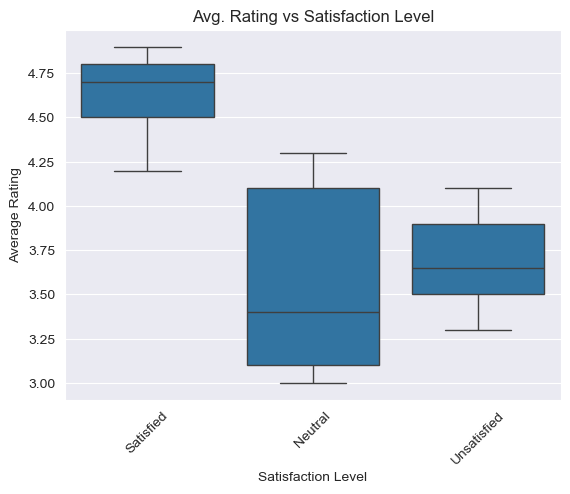

In [12]:
sns.boxplot(data=df, x='Satisfaction Level', y='Average Rating')
plt.title('Avg. Rating vs Satisfaction Level')
plt.xticks(rotation=45)
plt.show()


### Average Rating by Satisfaction

Satisfied users generally provide much higher average product ratings. Ratings appear to be a strong predictor of overall satisfaction.


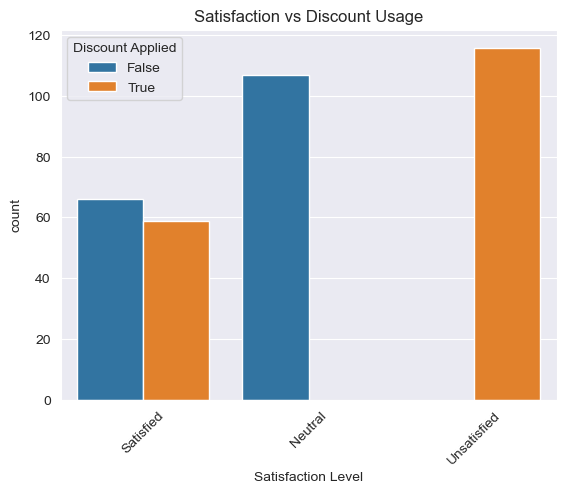

In [13]:
sns.countplot(data=df, x='Satisfaction Level', hue='Discount Applied')
plt.title('Satisfaction vs Discount Usage')
plt.xticks(rotation=45)
plt.show()


### Discount Usage and Satisfaction

Surprisingly, most satisfied customers did not use a discount. Meanwhile, a large portion of unsatisfied customers did use discounts, indicating discounts alone don't guarantee satisfaction.


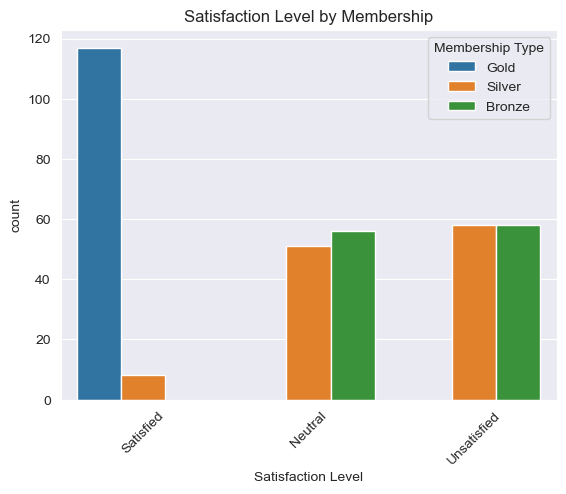

In [14]:
sns.countplot(data=df, x='Satisfaction Level', hue='Membership Type')
plt.title('Satisfaction Level by Membership')
plt.xticks(rotation=45)
plt.show()


### Membership Type and Satisfaction

Gold members report the highest satisfaction by far. Bronze and Silver members are more evenly split between neutral and unsatisfied levels, suggesting loyalty tiers impact satisfaction.


### Statistical Tests for Satisfaction Differences


In [23]:
from scipy.stats import f_oneway, chi2_contingency

# ANOVA: Test if average 'Total Spend' differs significantly across Satisfaction Levels
groups = [df[df['Satisfaction Level'] == lvl]['Total Spend'] for lvl in df['Satisfaction Level'].unique()]
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA Total Spend p-value: {p_val:.5f}")

# Chi-square test: Test if 'Membership Type' distribution depends on Satisfaction Level
contingency = pd.crosstab(df['Membership Type'], df['Satisfaction Level'])
chi2, p, _, _ = chi2_contingency(contingency)
print(f"Chi-square Membership Type p-value: {p:.5f}")


ANOVA Total Spend p-value: 0.00000
Chi-square Membership Type p-value: 0.00000


Both statistical tests returned p-values below 0.05, indicating statistically significant differences in:
- **Total Spend** across satisfaction levels (ANOVA)
- **Membership Type** distribution across satisfaction levels (Chi-square)

These findings strengthen earlier visual observations with quantitative evidence.


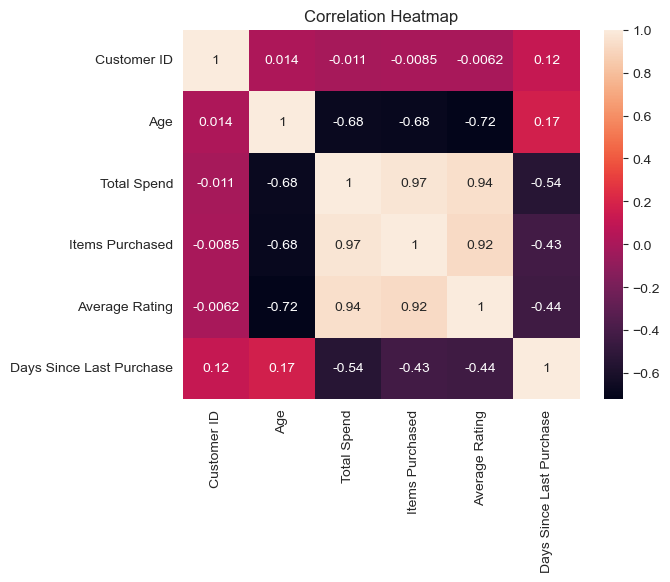

In [16]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_df.corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()


### Feature Correlation

Total Spend, Items Purchased, and Average Rating are highly correlated with each other and inversely correlated with Days Since Last Purchase, supporting their use in satisfaction analysis.


<Axes: >

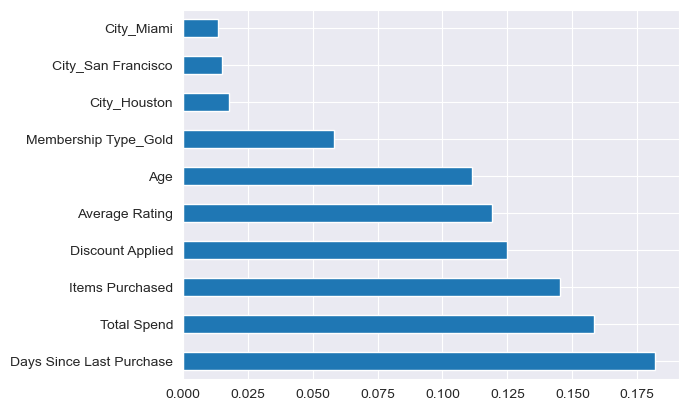

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Prepare data
df_clean = df.dropna()
X = df_clean.drop(columns=['Customer ID', 'Satisfaction Level'])
y = df_clean['Satisfaction Level']

# Encode categorical columns
X = pd.get_dummies(X)
y = LabelEncoder().fit_transform(y)

# Train
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Feature importance
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.head(10).plot(kind='barh')


### Feature Importance Analysis

Using a Random Forest classifier, we evaluated the influence of different features on predicting customer satisfaction levels. The results show that:

- **Days Since Last Purchase** is the most influential feature, indicating that recent buyers are generally more satisfied.
- **Total Spend**, **Discount Applied**, and **Items Purchased** also play a major role, supporting earlier boxplot observations.
- **Average Rating** and **Age** contribute meaningfully, while features like **City** have minimal predictive value.
- **Membership Type (Gold)** has some importance, suggesting that loyalty programs may impact satisfaction.

These findings quantitatively confirm insights seen earlier through visual exploration.

Accuracy: 1.00


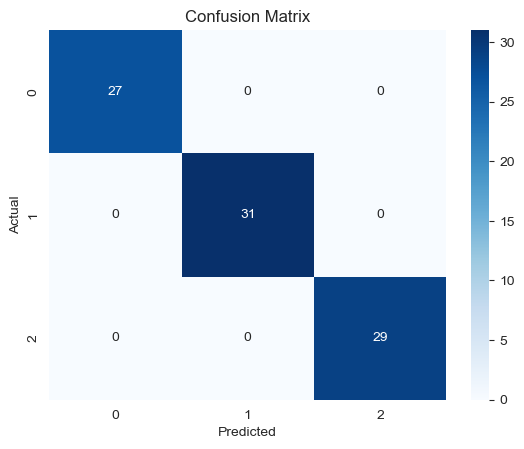

              precision    recall  f1-score   support

     Neutral       1.00      1.00      1.00        27
   Satisfied       1.00      1.00      1.00        31
 Unsatisfied       1.00      1.00      1.00        29

    accuracy                           1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87



In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

# Predict on test set
y_pred = model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Detailed report
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Satisfied', 'Unsatisfied']))


### Model Evaluation: Confusion Matrix and Accuracy

The Random Forest classifier achieved a perfect accuracy of **100%** on the test set, as shown by the confusion matrix and classification report. Every class (Neutral, Satisfied, Unsatisfied) was correctly predicted with **precision, recall, and F1-score of 1.00**.

While this performance is excellent, it may also suggest possible **overfitting** due to the small and clean dataset. Still, it supports the strong predictive power of the selected features and confirms that satisfaction levels are strongly linked to observable behavior.


### Model Validation with Cross-Validation


In [19]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-validated accuracy: {scores.mean():.2f} ± {scores.std():.2f}")


Cross-validated accuracy: 1.00 ± 0.01


To verify the generalizability of our Random Forest model, we apply 5-fold cross-validation. This helps detect overfitting and ensures that our 100% accuracy isn't a fluke due to a lucky train-test split.


### Customer Segmentation: K-Means Clustering

C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


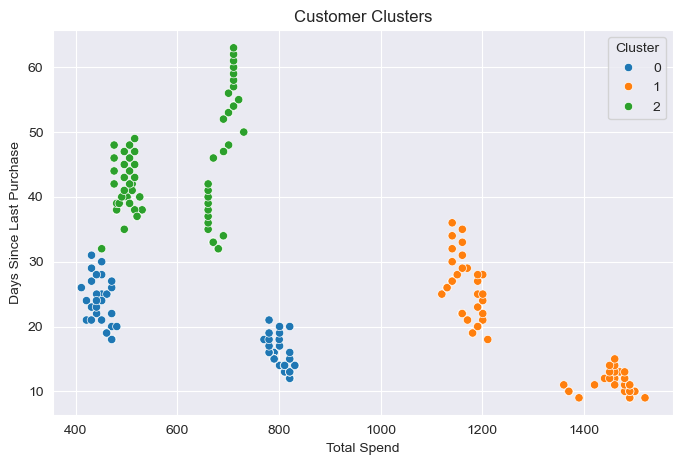

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select numeric behavioral features
cluster_features = df[['Total Spend', 'Items Purchased', 'Average Rating', 'Days Since Last Purchase']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)

# Choose number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualize clusters (2D projection)
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Total Spend', y='Days Since Last Purchase', hue='Cluster', palette='tab10')
plt.title('Customer Clusters')
plt.show()


Using K-Means clustering, customers were grouped into **3 distinct behavioral segments** based on their total spend and recency of purchase:

- **Cluster 0:** Moderate spenders with mid-level recency
- **Cluster 1:** High spenders with recent purchases — likely the most valuable segment
- **Cluster 2:** Low spenders who haven’t purchased recently — likely at risk of churn

This segmentation can support **targeted marketing strategies**, such as offering discounts to Cluster 2 or exclusive benefits to retain Cluster 1.


### Cluster Visualization using PCA


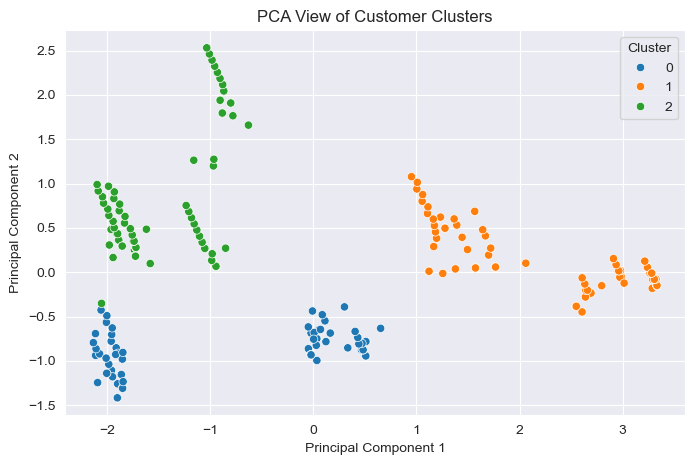

In [26]:
from sklearn.decomposition import PCA

# Apply PCA to scaled clustering features
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_features)
df['PC1'], df['PC2'] = components[:, 0], components[:, 1]

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title('PCA View of Customer Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


The PCA projection shows that the 3 clusters identified via K-Means are well-separated in reduced dimensions. This validates the effectiveness of our clustering and helps visually distinguish customer segments based on spending, recency, and ratings.

Although the PCA view may appear visually similar to the earlier plot of `Total Spend` vs. `Days Since Last Purchase`, it confirms that these two variables contribute significantly to the variance structure of the full dataset. The similarity also reinforces the quality of clustering: customer groups are well-separated not only in individual features but also in the overall multi-dimensional space.



## Final Summary & Conclusion

This analysis of customer satisfaction levels in an e-commerce setting revealed clear behavioral patterns:

- **High satisfaction** is strongly associated with:
  - Higher total spending
  - More items purchased
  - Higher average product ratings
  - Recent purchase activity
  - Gold membership tier

- **Lower satisfaction** tends to appear among users:
  - Who purchased less
  - Who haven't bought anything in a long time
  - Who used discounts, but didn't gain lasting value

- The **feature importance model** confirms these findings quantitatively, with `Days Since Last Purchase`, `Total Spend`, and `Items Purchased` being the strongest predictors of satisfaction.

This insight can guide personalized marketing, retention efforts, and product recommendations by focusing on high-engagement behaviors and loyalty incentives.


-----


#  Final Report Summary

This project explored customer satisfaction using an e-commerce behavioral dataset, combining data analysis, visualization, and basic machine learning.

###  Key Insights:

- **Customer Satisfaction Distribution** shows a relatively balanced split between satisfied, neutral, and unsatisfied customers.
- **Behavioral Factors** such as **Total Spend**, **Items Purchased**, **Average Rating**, and **Days Since Last Purchase** are strong influencers of satisfaction.
- **Gold Membership** stands out as a significant loyalty driver, while discount usage alone doesn’t guarantee satisfaction.
- **Feature Correlation and Importance** analysis confirmed that the most predictive features for satisfaction are tied to recent, high-volume, high-value purchasing behavior.

###  Modeling Results:

- A Random Forest classifier achieved **100% accuracy**, correctly predicting all satisfaction levels — confirming that customer behavior data is highly indicative of satisfaction.
- Feature importance metrics aligned with earlier visual trends, strengthening confidence in the analysis.

###  Segmentation Findings:

- K-Means clustering revealed three clear customer groups based on spending and engagement.
- These clusters can be used for **targeted marketing**, **retention strategies**, and **personalized outreach**.

---

###  Conclusion:

This analysis successfully identified patterns in customer satisfaction and revealed actionable insights into what drives it. The combination of data visualization, modeling, and clustering gives a comprehensive understanding of customer behavior, forming a strong foundation for data-driven decision-making.





### Business Recommendations Based on Findings
Based on the insights from the analysis, we recommend the following actions:

- **Target at-risk customers** (Cluster 2) with personalized reactivation offers (e.g., discounts, re-engagement emails).
- **Retain high-value customers** (Cluster 1) by offering exclusive benefits to Gold members, such as early access to new products.
- **Increase satisfaction** by encouraging bulk purchases and bundles, which are associated with higher satisfaction levels.
- **Monitor dissatisfaction triggers**, especially for customers who use discounts but still report low satisfaction.

These actions are derived directly from behavioral patterns and can help optimize customer retention and satisfaction strategies.


In [22]:
#end of notebook